# Derin Sahte (Deepfake) Ses Tanıma

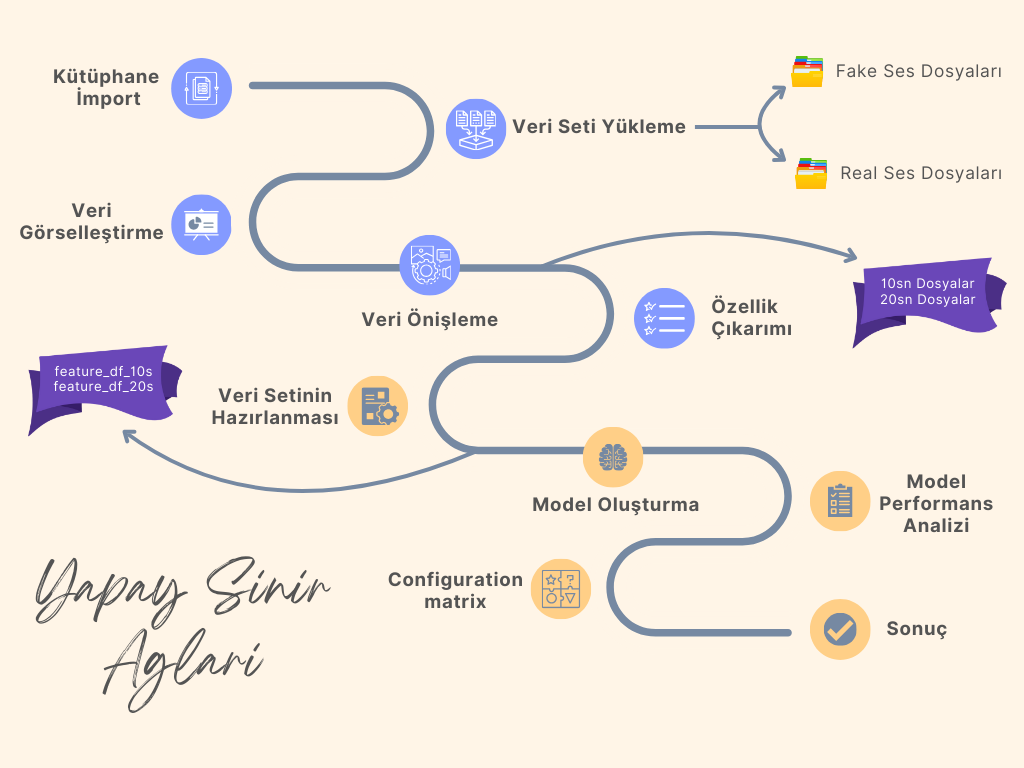
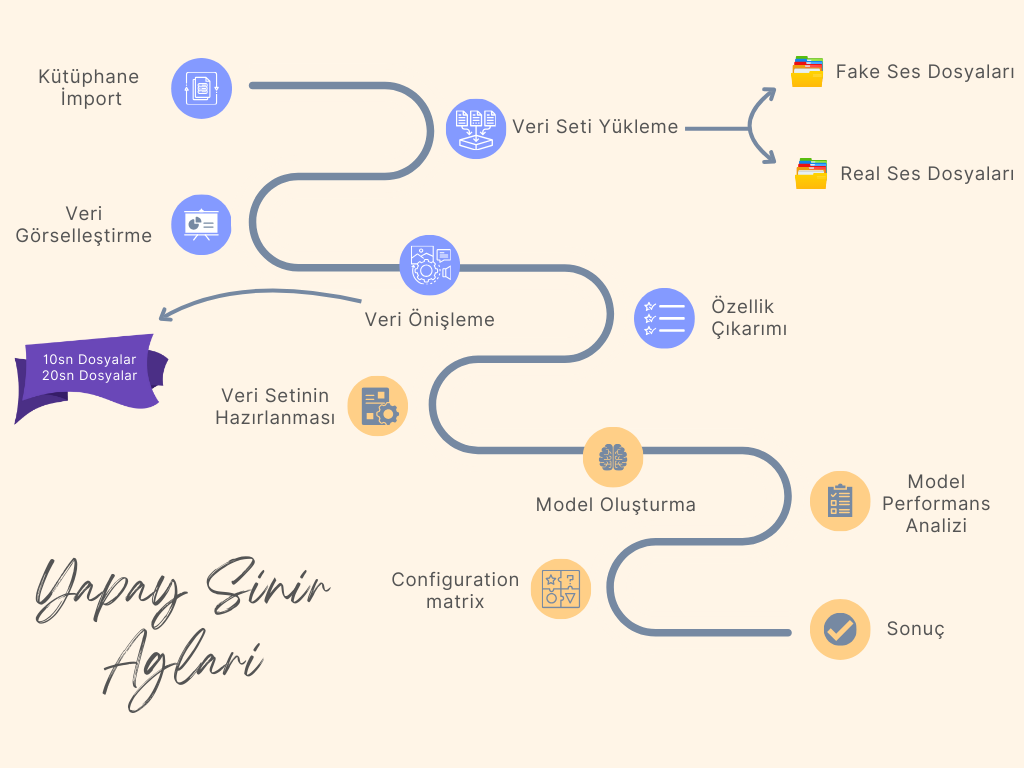

In [1]:
import numpy as np  # Lineer cebir işlemleri için kullanılan kütüphane
import pandas as pd # Veri işleme ve CSV dosyası giriş/çıkışı için kullanılan kütüphane

# Aşağıdaki kodu çalıştırmak (Shift+Enter tuşlarına basarak), bu dizin altındaki tüm dosyaları listeleyecektir.

# İşletim sistemi işlemleri (ör. dosya ve dizinleri listeleme) için kullanılan kütüphane
import os 
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/KAGGLE/DATASET-balanced.csv
/kaggle/input/KAGGLE/AUDIO/FAKE/trump-to-Obama.wav
/kaggle/input/KAGGLE/AUDIO/FAKE/margot-to-musk.wav
/kaggle/input/KAGGLE/AUDIO/FAKE/linus-to-obama.wav
/kaggle/input/KAGGLE/AUDIO/FAKE/taylor-to-trump.wav
/kaggle/input/KAGGLE/AUDIO/FAKE/taylor-to-biden.wav
/kaggle/input/KAGGLE/AUDIO/FAKE/ryan-to-trump.wav
/kaggle/input/KAGGLE/AUDIO/FAKE/obama-to-musk.wav
/kaggle/input/KAGGLE/AUDIO/FAKE/musk-to-trump.wav
/kaggle/input/KAGGLE/AUDIO/FAKE/ryan-to-musk.wav
/kaggle/input/KAGGLE/AUDIO/FAKE/trump-to-musk.wav
/kaggle/input/KAGGLE/AUDIO/FAKE/musk-to-ryan.wav
/kaggle/input/KAGGLE/AUDIO/FAKE/trump-to-Biden.wav
/kaggle/input/KAGGLE/AUDIO/FAKE/ryan-to-taylor.wav
/kaggle/input/KAGGLE/AUDIO/FAKE/taylor-to-margot.wav
/kaggle/input/KAGGLE/AUDIO/FAKE/taylor-to-linus.wav
/kaggle/input/KAGGLE/AUDIO/FAKE/biden-to-margot.wav
/kaggle/input/KAGGLE/AUDIO/FAKE/taylor-to-ryan.wav
/kaggle/input/KAGGLE/AUDIO/FAKE/ryan-to-biden.wav
/kaggle/input/KAGGLE/AUDIO/FAKE/ryan-to-oba

# Kütüphane Import İşlemleri

<p style="font-size: 20px;">Resampy, ses verileriyle (audio data) çalışmak için kullanılan bir Python kütüphanesidir.</p>


In [2]:
!pip install resampy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 35.7 MB/s eta 0:00:00


In [3]:
import numpy as np
import pandas as pd
import os
import librosa
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import IPython
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import RandomOverSampler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, Conv2D, MaxPool2D, Flatten
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

# Veri Seti Yükleme

<p style="font-size: 18px;">Bu projede kullanılan veri seti, Kaggle üzerinde yer alan "Deepfake Voice Recognition" veri setinden alınmıştır.Veri seti, sahte (FAKE) ve gerçek (REAL) ses dosyalarını içermektedir. Her bir ses dosyası belirli bir formatta (.wav) saklanmıştır.</p>

In [4]:
audio_files_path = "/kaggle/input/KAGGLE/AUDIO"

<p style="font-size: 18px;">os.listdir() fonksiyonu, belirtilen dizindeki alt klasörleri listelemek için kullanılmıştır. Bu projede, "FAKE" ve "REAL" adında iki alt klasör bulunmaktadır. Bu klasörler, ses dosyalarının sahte ya da gerçek olduğunu belirtmektedir.</p>

In [5]:
folders = os.listdir(audio_files_path)
print(folders)

['FAKE', 'REAL']


In [6]:
real_audio = "/kaggle/input/DEMONSTRATION/DEMONSTRATION/linus-original-DEMO.mp3"
fake_audio = "/kaggle/input/DEMONSTRATION/DEMONSTRATION/linus-to-musk-DEMO.mp3"

# Görselleştirme

In [7]:
# Veri dizinleri
audio_dir = "/kaggle/input/KAGGLE/AUDIO"
fake_audio_dir = "/kaggle/input/KAGGLE/AUDIO/FAKE"
real_audio_dir = "/kaggle/input/KAGGLE/AUDIO/REAL"

# FAKE ve REAL dosyalarını listeleme
fake_files = [os.path.join(fake_audio_dir, file) for file in os.listdir(fake_audio_dir)]
real_files = [os.path.join(real_audio_dir, file) for file in os.listdir(real_audio_dir)]

print(f"FAKE dosya sayısı: {len(fake_files)}")
print(f"REAL dosya sayısı: {len(real_files)}")

FAKE dosya sayısı: 56
REAL dosya sayısı: 8


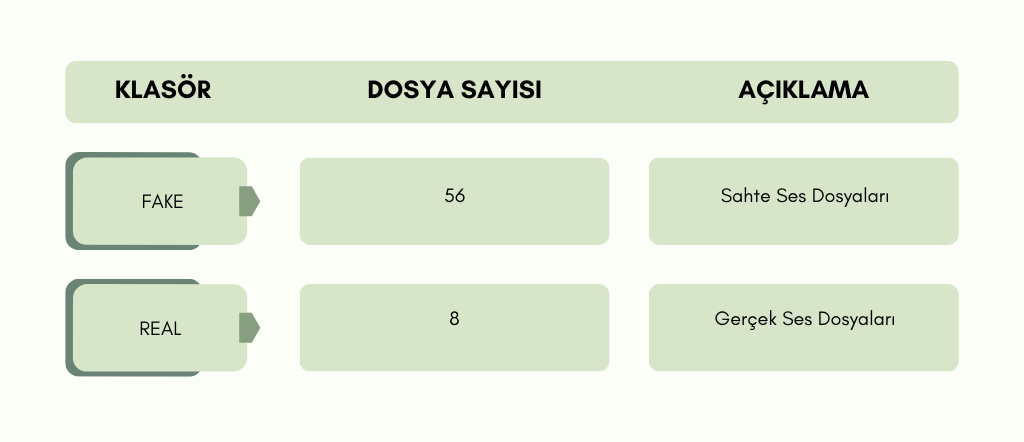

<p style="font-size: 20px;">Gerçek ses dosyasını yükleme ve 'plt.plot()' fonksiyonu ile yüklenen ses sinyalinin dalga formunu görselleştirme</p>

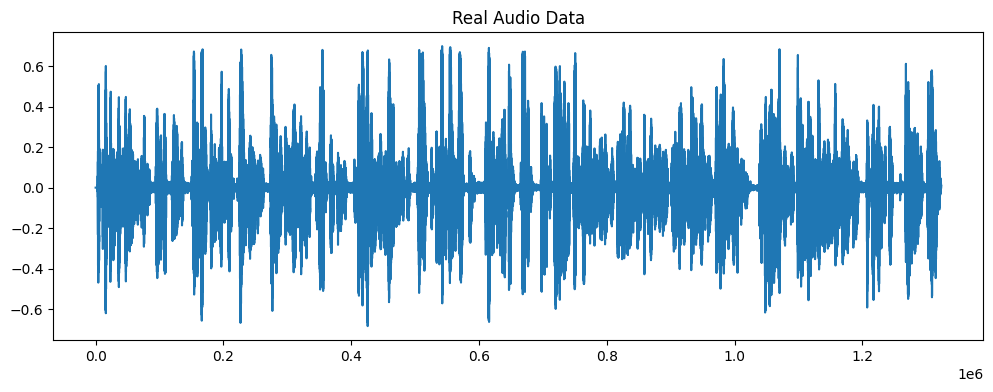

In [8]:
real_ad, real_sr = librosa.load(real_audio)
plt.figure(figsize=(12, 4))
plt.plot(real_ad)
plt.title("Real Audio Data")
plt.show()

In [9]:
# Ses dosyasını yükleyin
fake_audio_path = "/kaggle/input/KAGGLE/AUDIO/FAKE/trump-to-Obama.wav"
fake_ad, fake_sr = librosa.load(fake_audio_path)

print(f"Ses sinyali boyutu: {fake_ad.shape}")
print(f"Örnekleme oranı: {fake_sr}")


Ses sinyali boyutu: (13230000,)
Örnekleme oranı: 22050


# Gerçek ses verilerinin spektrogram çeşitlerinde oluşturma ve görselleştirme

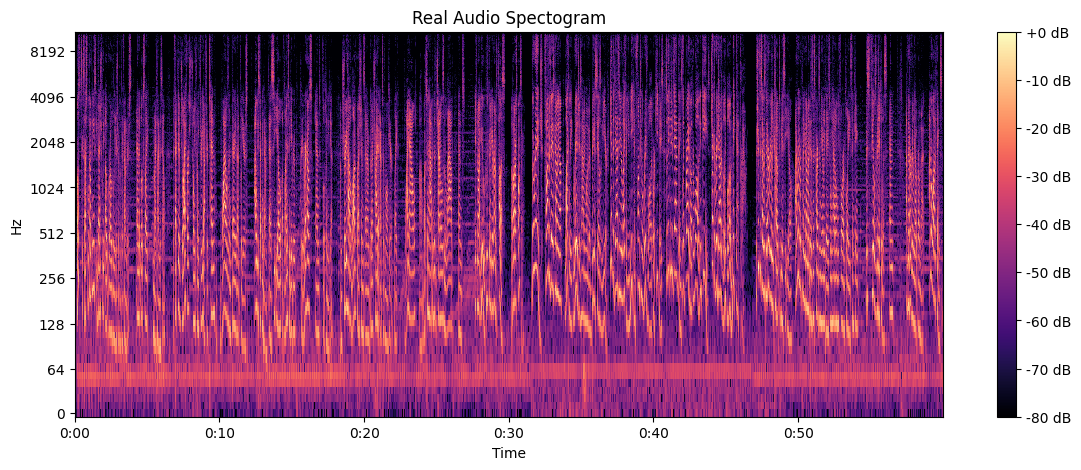

In [10]:
real_spec = np.abs(librosa.stft(real_ad))
real_spec = librosa.amplitude_to_db(real_spec, ref=np.max)

plt.figure(figsize=(14, 5))
librosa.display.specshow(real_spec, sr=real_sr, x_axis="time", y_axis="log")
plt.colorbar(format="%+2.0f dB")
plt.title("Real Audio Spectogram")
plt.show()

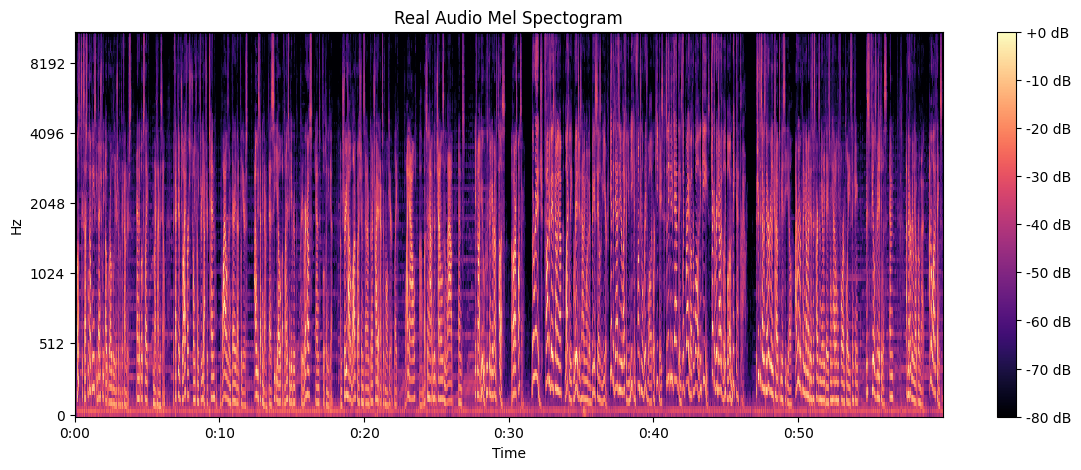

In [11]:
real_mel_spect = librosa.feature.melspectrogram(y=real_ad, sr=real_sr)
real_mel_spect = librosa.power_to_db(real_mel_spect, ref=np.max)

plt.figure(figsize=(14, 5))
librosa.display.specshow(real_mel_spect, y_axis="mel", x_axis="time")
plt.title("Real Audio Mel Spectogram")
plt.colorbar(format="%+2.0f dB")
plt.show()

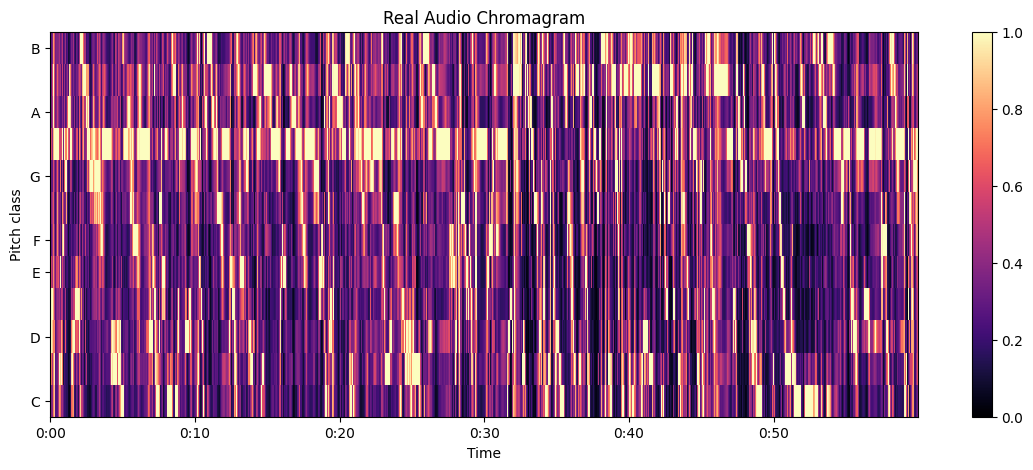

In [12]:
real_chroma = librosa.feature.chroma_cqt(y=real_ad, sr=real_sr, bins_per_octave=36)

plt.figure(figsize=(14, 5))
librosa.display.specshow(real_chroma, sr=real_sr, x_axis="time", y_axis="chroma", vmin=0, vmax=1)
plt.colorbar()
plt.title("Real Audio Chromagram")
plt.show()

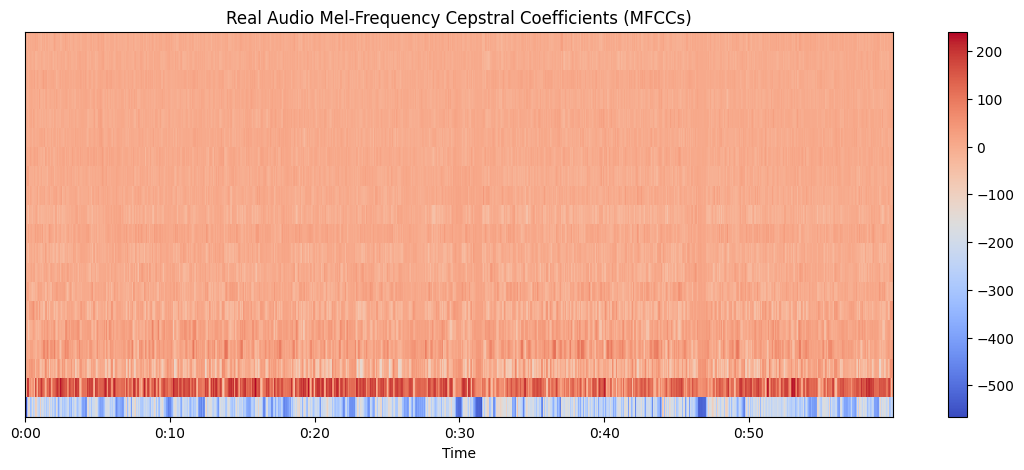

In [13]:
real_mfccs = librosa.feature.mfcc(y=real_ad, sr=real_sr)

plt.figure(figsize=(14, 5))
librosa.display.specshow(real_mfccs, sr=real_sr, x_axis="time")
plt.colorbar()
plt.title("Real Audio Mel-Frequency Cepstral Coefficients (MFCCs)")
plt.show()

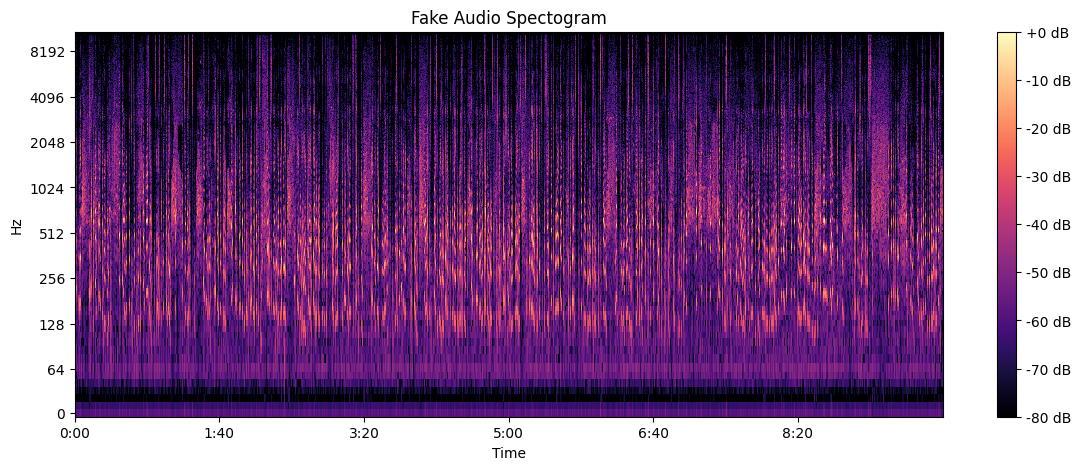

In [14]:
fake_spec = np.abs(librosa.stft(fake_ad))
fake_spec = librosa.amplitude_to_db(fake_spec, ref=np.max)

plt.figure(figsize=(14, 5))
librosa.display.specshow(fake_spec, sr=fake_sr, x_axis="time", y_axis="log")
plt.colorbar(format="%+2.0f dB")
plt.title("Fake Audio Spectogram")
plt.show()

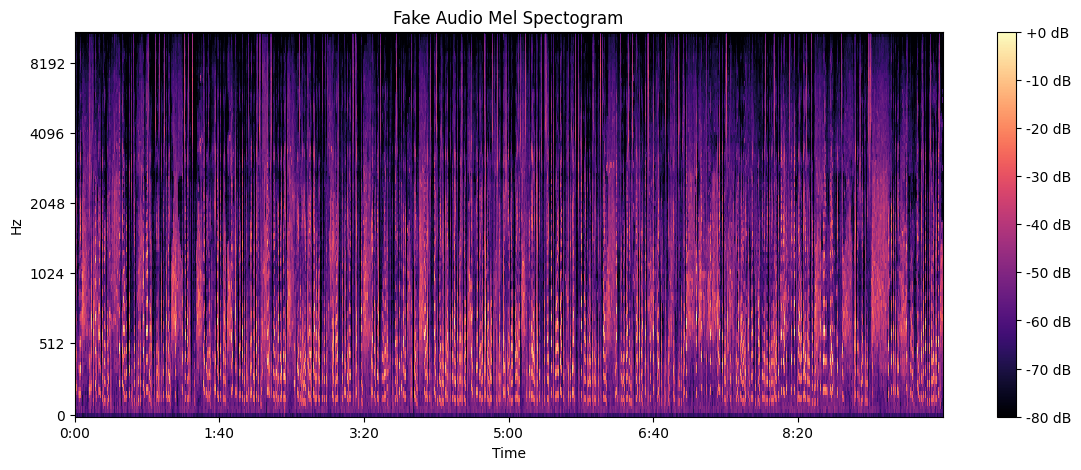

In [15]:
fake_mel_spect = librosa.feature.melspectrogram(y=fake_ad, sr=fake_sr)
fake_mel_spect = librosa.power_to_db(fake_mel_spect, ref=np.max)

plt.figure(figsize=(14, 5))
librosa.display.specshow(fake_mel_spect, y_axis="mel", x_axis="time")
plt.title("Fake Audio Mel Spectogram")
plt.colorbar(format="%+2.0f dB")
plt.show()

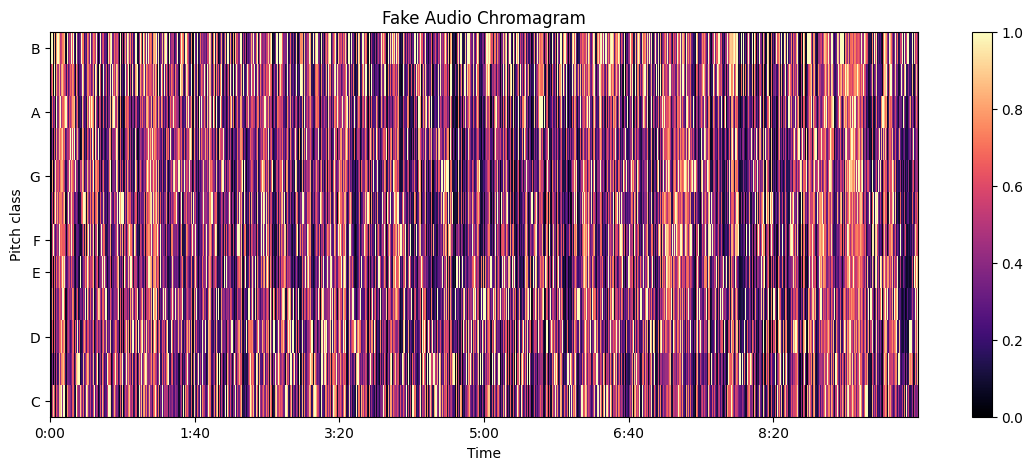

In [16]:
fake_chroma = librosa.feature.chroma_cqt(y=fake_ad, sr=fake_sr, bins_per_octave=36)

plt.figure(figsize=(14, 5))
librosa.display.specshow(fake_chroma, sr=fake_sr, x_axis="time", y_axis="chroma", vmin=0, vmax=1)
plt.colorbar()
plt.title("Fake Audio Chromagram")
plt.show()

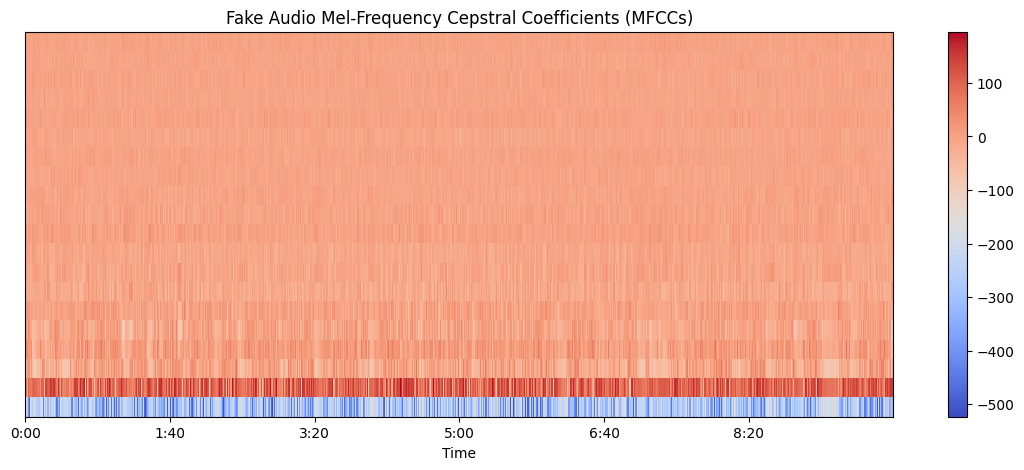

In [17]:
fake_mfccs = librosa.feature.mfcc(y=fake_ad, sr=fake_sr)

plt.figure(figsize=(14, 5))
librosa.display.specshow(fake_mfccs, sr=fake_sr, x_axis="time")
plt.colorbar()
plt.title("Fake Audio Mel-Frequency Cepstral Coefficients (MFCCs)")
plt.show()

# Veri Önişleme

<p style="font-size: 15px;">
Bu kod bloğu, FAKE ve REAL ses dosyalarını işleyerek belirli sürelerde (örneğin, 10 saniyelik) parçalara ayırmayı ve bu parçaları bellek üzerinde saklamayı amaçlamaktadır. Ses dosyaları, Kaggle dizinindeki FAKE ve REAL alt klasörlerinden alınmakta ve .wav formatındaki dosyalar kullanılmaktadır. İşlem sırasında şu adımlar gerçekleştirilmektedir:
<br><br>
1. <b>Veri Hazırlığı:</b> Ses dosyaları dizinlerden yüklenir ve FAKE/REAL olarak sınıflandırılır. Bu sınıflandırma, etiketleme (labeling) süreci için gereklidir.
<br><br>
2. <b>Ses Dosyalarını Parçalama:</b> Her bir ses dosyası, 10 saniyelik sürelerle eşit uzunluklarda parçalara ayrılır. Parçalar (chunks), orijinal dosya adı ve parça numarasına göre adlandırılır. Her bir parça, ses verisi ve etiketi (FAKE/REAL) ile birlikte bellekte saklanır.
<br><br>
3. <b>Verinin Saklanması:</b> Parçalanan ses dosyaları bir sözlükte (audio_chunks) saklanır. Etiketler ve parça bilgileri, analiz veya model eğitimi için pandas.DataFrame formatına dönüştürülür.
<br><br>
4. <b>Özet ve Çıktılar:</b> FAKE ve REAL dosyalarının toplam parça sayıları hesaplanır ve ekrana yazdırılır. Bellekte saklanan parçalar, daha sonra kullanılmak üzere organize edilir.
</p>


In [18]:
import os
from pydub import AudioSegment
from pydub.utils import make_chunks
import pandas as pd

# Veri dizinleri
audio_dir = "/kaggle/input/KAGGLE/AUDIO"
fake_audio_dir = os.path.join(audio_dir, "FAKE")
real_audio_dir = os.path.join(audio_dir, "REAL")

# FAKE ve REAL dosyalarını listeleme
fake_files = [os.path.join(fake_audio_dir, file) for file in os.listdir(fake_audio_dir) if file.endswith(".wav")]
real_files = [os.path.join(real_audio_dir, file) for file in os.listdir(real_audio_dir) if file.endswith(".wav")]

print(f"FAKE dosya sayısı: {len(fake_files)}")
print(f"REAL dosya sayısı: {len(real_files)}")

# Bellekte veriyi saklamak için yapılar
audio_chunks_10s = {}  # 10 saniyelik parçalar
audio_chunks_20s = {}  # 20 saniyelik parçalar

# Fonksiyon: Bellekte parçalama
def process_audio_files(file_list, label, chunk_duration_ms):
    """
    Ses dosyalarını verilen süreye göre parçalayan ve verileri bellekte saklayan fonksiyon.
    """
    chunks_dict = {}
    count = 0  # Her sınıf için parça sayısını takip et
    for audio_path in file_list:
        file_name = os.path.basename(audio_path)
        audio = AudioSegment.from_file(audio_path, format="wav")
        
        # Parçalama
        chunks = make_chunks(audio, chunk_duration_ms)
        for i, chunk in enumerate(chunks):
            chunk_name = f"{os.path.splitext(file_name)[0]}_chunk{i}_{chunk_duration_ms}ms"
            
            # Parçayı ve etiketini sakla
            chunks_dict[chunk_name] = {"chunk": chunk, "label": label}
            count += 1
    return chunks_dict, count

# 10 saniyelik parçalama
print("10 saniyelik parçalama başlatılıyor...")
audio_chunks_10s_fake, fake_chunk_count_10s = process_audio_files(fake_files, "FAKE", 10000)
audio_chunks_10s_real, real_chunk_count_10s = process_audio_files(real_files, "REAL", 10000)
audio_chunks_10s.update(audio_chunks_10s_fake)
audio_chunks_10s.update(audio_chunks_10s_real)

# 20 saniyelik parçalama
print("20 saniyelik parçalama başlatılıyor...")
audio_chunks_20s_fake, fake_chunk_count_20s = process_audio_files(fake_files, "FAKE", 20000)
audio_chunks_20s_real, real_chunk_count_20s = process_audio_files(real_files, "REAL", 20000)
audio_chunks_20s.update(audio_chunks_20s_fake)
audio_chunks_20s.update(audio_chunks_20s_real)

# Çıktılar
print(f"10 saniyelik toplam parça sayısı: {len(audio_chunks_10s)}")
print(f"20 saniyelik toplam parça sayısı: {len(audio_chunks_20s)}")


FAKE dosya sayısı: 56
REAL dosya sayısı: 8
10 saniyelik parçalama başlatılıyor...
20 saniyelik parçalama başlatılıyor...
10 saniyelik toplam parça sayısı: 3013
20 saniyelik toplam parça sayısı: 1509


<p style="font-size: 15px;">Aşağıdaki  kod bloğu, FAKE ve REAL olarak sınıflandırılmış ses dosyalarının parçalarından (chunks) özellik çıkarımı (feature extraction) yapmak ve bunları sınıf etiketleriyle birlikte saklamak için kullanılmaktadır. Özellik çıkarımı sırasında Mel-Frekans Kepstral Katsayıları (MFCC) hesaplanmış ve bu özellikler ölçeklendirilmiştir. İşlem sırasında şu adımlar gerçekleştirilmiştir:
<br><br>
1. <b>Ses Parçalarının İşlenmesi:</b> Bellekte saklanan her bir ses parçası (chunk) üzerinde işlem yapılmıştır. 
- Parçanın sesi NumPy array'e dönüştürülerek, Pydub'dan elde edilen veriler işlenebilir hale getirilmiştir.
- Parçanın sınıf etiketi (FAKE veya REAL) tanımlanmış ve daha sonraki işlemler için kaydedilmiştir.
<br><br>
2. <b>MFCC Özelliklerinin Çıkarılması:</b> Her ses parçası için MFCC (Mel-Frekans Kepstral Katsayıları) özellikleri hesaplanmıştır. 
- Özellik çıkarımı, sesin spektral özelliklerini analiz etmeye olanak sağlar.
- 40 MFCC katsayısı hesaplanmış ve zaman boyunca ortalaması alınarak ölçeklendirilmiştir.
<br><br>
3. <b>Özellik ve Etiketlerin Saklanması:</b> Çıkarılan MFCC özellikleri `data` listesinde, parçaların sınıf etiketleri (FAKE veya REAL) ise `labels` listesinde saklanmıştır. Bu yapılar, daha sonra bir makine öğrenimi veya derin öğrenme modeline giriş verisi olarak kullanılacaktır.
<br><br>
4. <b>Özet ve Çıktılar:</b> 
- İşlemin sonunda çıkarılan toplam veri sayısı, FAKE ve REAL parça sayıları ile birlikte özetlenmiştir.
- Hatalı parçalar işlem sırasında tespit edilmiş ve hata mesajları ekrana yazdırılmıştır.
<br><br>
Bu adımlar, ses verisinin sınıflandırma veya analiz projelerine hazırlanması için kritik bir ön işleme aşamasıdır.
</p>


In [19]:
from tqdm import tqdm
import numpy as np
import librosa

# MFCC özellik çıkarımı fonksiyonu
def extract_features(audio_chunks):
    """
    Verilen ses parçalarından MFCC özelliklerini çıkarır.
    """
    data = []
    labels = []
    for chunk_name, chunk_data in tqdm(audio_chunks.items()):
        try:
            chunk = chunk_data["chunk"]
            label = chunk_data["label"]
            
            # Pydub'dan NumPy array'e dönüştür
            samples = np.array(chunk.get_array_of_samples(), dtype=np.float32)
            sample_rate = chunk.frame_rate

            # MFCC özelliklerini hesapla
            mfccs_features = librosa.feature.mfcc(y=samples, sr=sample_rate, n_mfcc=40, n_fft=512)
            mfccs_features_scaled = np.mean(mfccs_features.T, axis=0)

            # Özellikleri ve etiketi kaydet
            data.append(mfccs_features_scaled)
            labels.append(label)
        except Exception as e:
            print(f"Hata oluştu: {chunk_name} - {e}")
    return data, labels

# 10 saniyelik parçalar için MFCC özellik çıkarımı
print("10 saniyelik parçalar için özellik çıkarımı yapılıyor...")
data_10s, labels_10s = extract_features(audio_chunks_10s)

# 20 saniyelik parçalar için MFCC özellik çıkarımı
print("20 saniyelik parçalar için özellik çıkarımı yapılıyor...")
data_20s, labels_20s = extract_features(audio_chunks_20s)

# Sonuçların özeti
print("-----------------------------------------")
print(f"10 saniyelik veri sayısı: {len(data_10s)}")
print(f"10 saniyelik FAKE parça sayısı: {labels_10s.count('FAKE')}")
print(f"10 saniyelik REAL parça sayısı: {labels_10s.count('REAL')}")
print("-----------------------------------------")
print(f"20 saniyelik veri sayısı: {len(data_20s)}")
print(f"20 saniyelik FAKE parça sayısı: {labels_20s.count('FAKE')}")
print(f"20 saniyelik REAL parça sayısı: {labels_20s.count('REAL')}")

10 saniyelik parçalar için özellik çıkarımı yapılıyor...


  0%|          | 0/3013 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/librosa/feature/spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
 89%|████████▉ | 2692/3013 [00:57<00:07, 43.76it/s]/opt/conda/lib/python3.10/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=512 is too large for input signal of length=288
  warnings.warn(
100%|██████████| 3013/3013 [01:05<00:00, 46.18it/s]


20 saniyelik parçalar için özellik çıkarımı yapılıyor...


100%|██████████| 1509/1509 [00:58<00:00, 25.66it/s]

-----------------------------------------
10 saniyelik veri sayısı: 3013
10 saniyelik FAKE parça sayısı: 2632
10 saniyelik REAL parça sayısı: 381
-----------------------------------------
20 saniyelik veri sayısı: 1509
20 saniyelik FAKE parça sayısı: 1316
20 saniyelik REAL parça sayısı: 193


<p style="font-size: 20px;">Oluşturulan veri çerçevesindeki (DataFrame) sınıf etiketlerinin dağılımını analiz etmek için kullanılmaktadır.</p>

# feature_df ve Veri Seti Hazırlığı

In [20]:
# 10 saniyelik veri için feature_df oluştur
feature_df_10s = pd.DataFrame({
    "features": data_10s,
    "class": labels_10s
})

# 20 saniyelik veri için feature_df oluştur
feature_df_20s = pd.DataFrame({
    "features": data_20s,
    "class": labels_20s
})

# Her iki veri seti için sınıf dağılımını kontrol et
print("10 saniyelik veri sınıf dağılımı:")
print(feature_df_10s["class"].value_counts())
print("-----------------------------------")
print("20 saniyelik veri sınıf dağılımı:")
print(feature_df_20s["class"].value_counts())


10 saniyelik veri sınıf dağılımı:
class
FAKE    2632
REAL     381
Name: count, dtype: int64
-----------------------------------
20 saniyelik veri sınıf dağılımı:
class
FAKE    1316
REAL     193
Name: count, dtype: int64


<p style="font-size: 16px;">
Bu kod bloğu, bir sütundaki kategorik verileri sayısal verilere dönüştürmek (label encoding) için bir fonksiyon tanımlar. Bu işlem, makine öğrenimi ve derin öğrenme modellerinde kategorik verilerin kullanılabilmesi için gereklidir. Fonksiyonun işlevi şu adımlardan oluşmaktadır:
<br><br>
1. <b>LabelEncoder Nesnesi Oluşturma:</b>
- `LabelEncoder()`, sklearn kütüphanesinde yer alan bir sınıftır. Kategorik değerleri (örneğin, "FAKE" ve "REAL") sayısal değerlere (örneğin, 0 ve 1) dönüştürmek için kullanılır.
- `fit(column)`, belirtilen sütunda yer alan tüm benzersiz değerleri öğrenir ve bunlara birer sayısal etiket atar.
<br><br>
2. <b>Label Encoding İşlemi:</b>
- `le.classes_`, sütundaki tüm benzersiz kategorik değerleri sıralı bir şekilde listeler ve bu değerlerin hangi sırayla dönüştürüldüğünü gösterir.
- `transform(column)`, sütundaki kategorik değerleri, her bir değere karşılık gelen sayısal etiketlere dönüştürür.
<br><br>
3. <b>Sonuç:</b>
- Fonksiyon, dönüştürülen sayısal değerleri döndürür. Bu sayede, makine öğrenimi veya derin öğrenme modellerinde kullanılabilir hale gelir.
<br><br>
Bu işlem, özellikle FAKE ve REAL gibi kategorik sınıfların 0 ve 1 gibi sayısal değerlere dönüştürülmesi gerektiğinde kullanışlıdır.
</p>


# Etiket Kodlama (Label Encoding)

In [21]:
from sklearn.preprocessing import LabelEncoder

def label_encoder(column):
    le = LabelEncoder().fit(column)
    print(column.name, le.classes_)
    return le.transform(column)

# 10s ve 20s verilerinin etiketlerini kodlama
feature_df_10s["encoded_class"] = label_encoder(feature_df_10s["class"])
feature_df_20s["encoded_class"] = label_encoder(feature_df_20s["class"])

class ['FAKE' 'REAL']
class ['FAKE' 'REAL']


# Özellik ve Etiket Ayrımı

In [22]:
# 10s verileri için
X_10s = np.array(feature_df_10s["features"].tolist())
y_10s = np.array(feature_df_10s["encoded_class"].tolist())

# 20s verileri için
X_20s = np.array(feature_df_20s["features"].tolist())
y_20s = np.array(feature_df_20s["encoded_class"].tolist())


# Verileri Eğitim ve Test Setine Bölme

In [23]:
from sklearn.model_selection import train_test_split

# 10s verileri için
X_train_10s, X_test_10s, y_train_10s, y_test_10s = train_test_split(
    X_10s, y_10s, test_size=0.2, random_state=42
)

# 20s verileri için
X_train_20s, X_test_20s, y_train_20s, y_test_20s = train_test_split(
    X_20s, y_20s, test_size=0.2, random_state=42
)

In [24]:
from sklearn.preprocessing import MinMaxScaler

# Normalizasyon
scaler_10s = MinMaxScaler()
X_train_10s = scaler_10s.fit_transform(X_train_10s)
X_test_10s = scaler_10s.transform(X_test_10s)

scaler_20s = MinMaxScaler()
X_train_20s = scaler_20s.fit_transform(X_train_20s)
X_test_20s = scaler_20s.transform(X_test_20s)


# Model Eğitimi

In [25]:
print("y_train_10s shape:", y_train_10s.shape)
print("y_test_10s shape:", y_test_10s.shape)
print("y_train_20s shape:", y_train_20s.shape)
print("y_test_20s shape:", y_test_20s.shape)


y_train_10s shape: (2410,)
y_test_10s shape: (603,)
y_train_20s shape: (1207,)
y_test_20s shape: (302,)


In [26]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

# Etiketleri kategorik hale getirme
y_train_10s = to_categorical(y_train_10s)
y_test_10s = to_categorical(y_test_10s)
y_train_20s = to_categorical(y_train_20s)
y_test_20s = to_categorical(y_test_20s)

# Model yapısı
def create_model(input_shape, num_labels):
    model = Sequential()
    model.add(Input(shape=input_shape))  # Giriş katmanı
    model.add(Dense(128, kernel_regularizer=l2(0.01)))
    model.add(Activation("relu"))
    model.add(Dropout(0.5))
    model.add(Dense(256))
    model.add(Activation("relu"))
    model.add(Dropout(0.5))
    model.add(Dense(128))
    model.add(Activation("relu"))
    model.add(Dropout(0.5))
    model.add(Dense(num_labels))
    model.add(Activation("softmax"))
    
    # Öğrenme oranını ayarlamak için optimizer kullanımı
    optimizer = Adam(learning_rate=0.0001)  # Daha düşük bir öğrenme oranı
    model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
    return model
    
    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
    return model

# Model oluşturma
input_shape_10s = (X_train_10s.shape[1],)
num_labels_10s = y_train_10s.shape[1]
model_10s = create_model(input_shape_10s, num_labels_10s)

input_shape_20s = (X_train_20s.shape[1],)
num_labels_20s = y_train_20s.shape[1]
model_20s = create_model(input_shape_20s, num_labels_20s)

# Model özeti
print("10s model özeti:")
model_10s.summary()
print("\n20s model özeti:")
model_20s.summary()

# Model eğitimi
early = EarlyStopping(monitor="val_loss", patience=10)

print("10s model eğitimi başlıyor...")
history_10s = model_10s.fit(
    X_train_10s, y_train_10s, validation_data=(X_test_10s, y_test_10s),
    batch_size=2, epochs=100, callbacks=[early]
)

print("20s model eğitimi başlıyor...")
history_20s = model_20s.fit(
    X_train_20s, y_train_20s, validation_data=(X_test_20s, y_test_20s),
    batch_size=2, epochs=100, callbacks=[early]
)

10s model özeti:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         5,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │           258 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 2)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 71,426 (279.01 KB)

 Trainable params: 71,426 (279.01 KB)

 Non-trainable params: 0 (0.00 B)


20s model özeti:


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 128)            │         5,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_6 (Activation)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 2)              │           258 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_7 (Activation)       │ (None, 2)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 71,426 (279.01 KB)

 Trainable params: 71,426 (279.01 KB)

 Non-trainable params: 0 (0.00 B)

10s model eğitimi başlıyor...
Epoch 1/100


I0000 00:00:1733811213.929295      89 service.cc:145] XLA service 0x7f2d900060a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733811213.929354      89 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1733811213.929360      89 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


 110/1205 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8287 - loss: 1.0846

I0000 00:00:1733811218.117490      89 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1205/1205 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.8619 - loss: 0.9483 - val_accuracy: 0.8789 - val_loss: 0.6817
Epoch 2/100
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8746 - loss: 0.7162 - val_accuracy: 0.9287 - val_loss: 0.5342
Epoch 3/100
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9029 - loss: 0.5673 - val_accuracy: 0.9486 - val_loss: 0.4349
Epoch 4/100
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9198 - loss: 0.5063 - val_accuracy: 0.9486 - val_loss: 0.3688
Epoch 5/100
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9346 - loss: 0.4177 - val_accuracy: 0.9635 - val_loss: 0.3081
Epoch 6/100
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9549 - loss: 0.3470 - val_accuracy: 0.9718 - val_loss: 0.2716
Epoch 7/100
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9589 - loss: 0.3108 - val_accuracy: 0.9917 - val_loss: 0.2504
Epoch 8/100
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9745 - loss: 0.2970 - val_

# Performans Karşılaştırması

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9982 - loss: 0.0499
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.9360 - loss: 0.3376
10s Model - Test Loss: 0.04877740144729614, Test Accuracy: 0.9983416199684143
20s Model - Test Loss: 0.34786131978034973, Test Accuracy: 0.9370861053466797


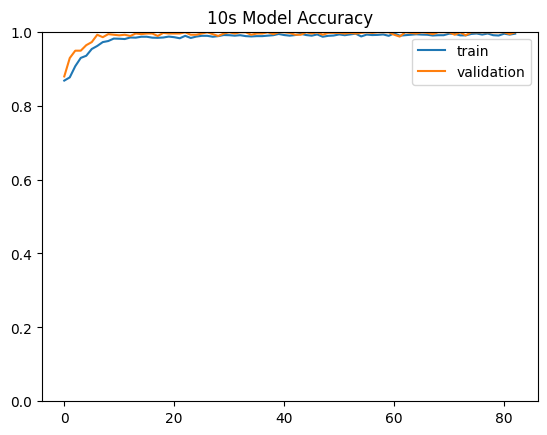

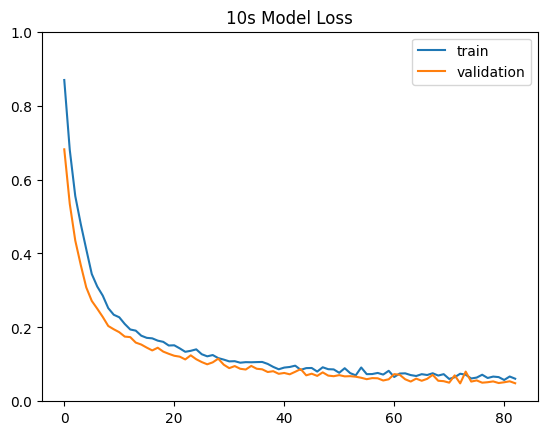

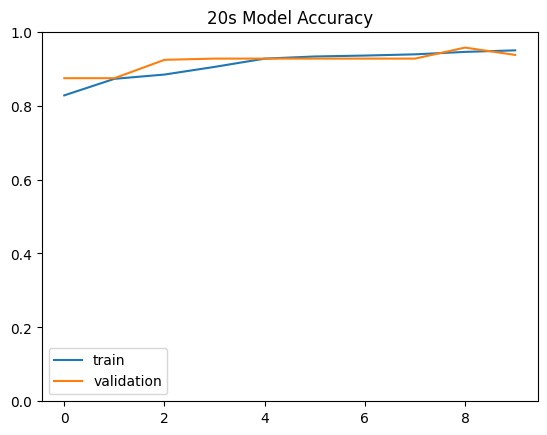

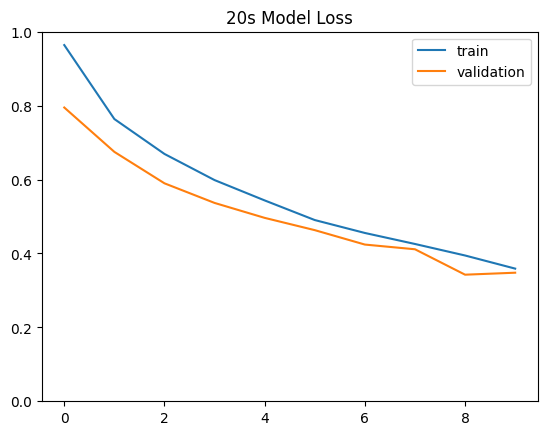

In [27]:
# Model doğrulama
test_loss_10s, test_acc_10s = model_10s.evaluate(X_test_10s, y_test_10s)
test_loss_20s, test_acc_20s = model_20s.evaluate(X_test_20s, y_test_20s)

print(f"10s Model - Test Loss: {test_loss_10s}, Test Accuracy: {test_acc_10s}")
print(f"20s Model - Test Loss: {test_loss_20s}, Test Accuracy: {test_acc_20s}")

# Eğitim/Doğrulama doğruluğu ve kaybı grafikleri
import matplotlib.pyplot as plt

# 10s Model
plt.figure()
plt.title("10s Model Accuracy")
plt.plot(history_10s.history["accuracy"], label="train")
plt.plot(history_10s.history["val_accuracy"], label="validation")
plt.legend()
plt.ylim([0, 1])
plt.show()

plt.figure()
plt.title("10s Model Loss")
plt.plot(history_10s.history["loss"], label="train")
plt.plot(history_10s.history["val_loss"], label="validation")
plt.legend()
plt.ylim([0, 1])
plt.show()

# 20s Model
plt.figure()
plt.title("20s Model Accuracy")
plt.plot(history_20s.history["accuracy"], label="train")
plt.plot(history_20s.history["val_accuracy"], label="validation")
plt.legend()
plt.ylim([0, 1])
plt.show()

plt.figure()
plt.title("20s Model Loss")
plt.plot(history_20s.history["loss"], label="train")
plt.plot(history_20s.history["val_loss"], label="validation")
plt.legend()
plt.ylim([0, 1])
plt.show()

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


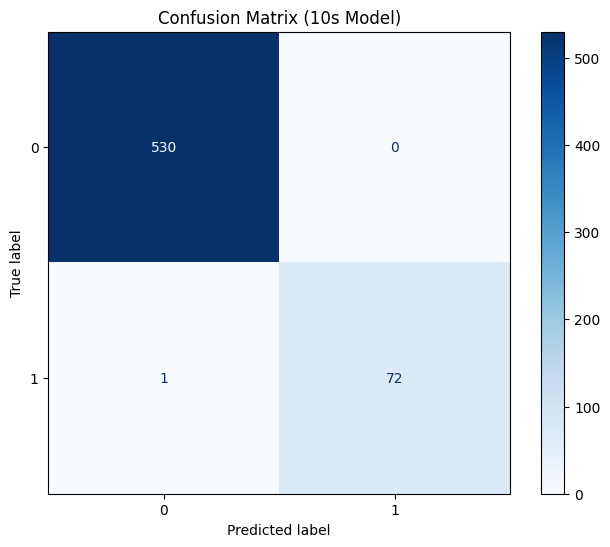

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Confusion Matrix Hesaplama
y_true_10s = np.argmax(y_test_10s, axis=1)  # Gerçek etiketler
y_pred_10s = np.argmax(model_10s.predict(X_test_10s), axis=1)  # Tahminler

# Matris Görselleştirme
cm = confusion_matrix(y_true_10s, y_pred_10s)
fig, ax = plt.subplots(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_true_10s))
disp.plot(ax=ax, cmap="Blues", values_format='d')

plt.title("Confusion Matrix (10s Model)")
plt.show()



10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


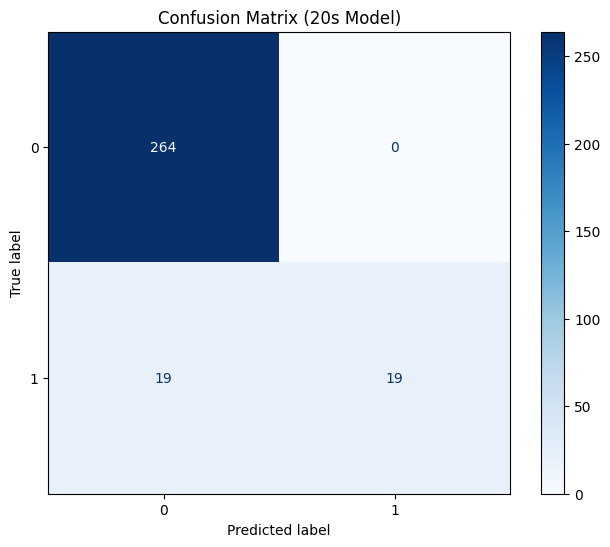

In [29]:
# Confusion Matrix Hesaplama
y_true_20s = np.argmax(y_test_20s, axis=1)  # Gerçek etiketler
y_pred_20s = np.argmax(model_20s.predict(X_test_20s), axis=1)  # Tahminler

# Matris Görselleştirme
cm = confusion_matrix(y_true_20s, y_pred_20s)
fig, ax = plt.subplots(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_true_20s))
disp.plot(ax=ax, cmap="Blues", values_format='d')

plt.title("Confusion Matrix (20s Model)")
plt.show()


# Güncelleme: Test ve Sonuç Karşılaştırması

In [30]:
def detect_fake(filename, model):
    sound_signal, sample_rate = librosa.load(filename, res_type="kaiser_fast")
    mfcc_features = librosa.feature.mfcc(y=sound_signal, sr=sample_rate, n_mfcc=40)
    mfccs_features_scaled = np.mean(mfcc_features.T, axis=0)
    mfccs_features_scaled = mfccs_features_scaled.reshape(1, -1)
    result_array = model.predict(mfccs_features_scaled)
    print(result_array)
    result_classes = ["FAKE", "REAL"]
    result = np.argmax(result_array[0])
    print("Result:", result_classes[result])

# Test dosyaları
test_real = "/kaggle/input/DEMONSTRATION/DEMONSTRATION/linus-original-DEMO.mp3"
test_fake = "/kaggle/input/DEMONSTRATION/DEMONSTRATION/linus-to-musk-DEMO.mp3"

print("10s Model Test:")
detect_fake(test_real, model_10s)
detect_fake(test_fake, model_10s)
print("--------------------------------------")
print("20s Model Test:")
detect_fake(test_real, model_20s)
detect_fake(test_fake, model_20s)

10s Model Test:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step
[[1. 0.]]
Result: FAKE
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
[[1. 0.]]
Result: FAKE
--------------------------------------
20s Model Test:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
[[0. 1.]]
Result: REAL
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
[[0. 1.]]
Result: REAL
